In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
# plt.style.use("~/.dracula.mplstyle")
from scipy import stats
import arch

In [2]:
xl = pd.ExcelFile("barnstable.xlsx")
print(xl.sheet_names)

de = xl.parse(xl.sheet_names[0])
print(de)

data = xl.parse(xl.sheet_names[1])
data.set_index("date", inplace=True)
data = data.interpolate() # Linearly fills NA in Treasuries
assert sum(sum(data.isna().values))==0
data.head()

['descriptions', 'data']
  Unnamed: 0               Description
0        SPX              S&P500 Index
1       TB1M  Treasury Bill (1M) Index


,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026
1926-03-31,-0.0577,0.0026
1926-04-30,0.0385,0.0023
1926-05-28,0.0136,0.0027


## 2. Estimating Underperformance

Use the returns on the S&P 500 (rM) and 1-month T-bills, (rf ) provided in “barnstable analysis data.xlsx”.

Barnstable’s estimates of mean and volatility are based on the subsample of 1965 to 1999. We consider this subsample, as well as 2000-2021, as well as the full sample of 1926-2021. We only have data through August of 2021, but no adjustment is needed for the fact that you have only the partial year–just use what you have.

#### 1. Summary Statistics

(a) Report the following (annualized) statistics.

In [3]:
# Log the returns
data["SPXEX"] = data["SPX"] - data["TB1M"]
for c in data.columns:
    data['log'+c] = np.log(data[c]+1)

data = data[sorted(data.columns)]

# Check if excess returns is calculated correctly
pd.concat([(data["SPXEX"]+1).cumprod(), np.exp(data["logSPXEX"].cumsum())], axis=1).tail()

,SPXEX,logSPXEX
date,,
2021-04-30,526.9951,526.9951
2021-05-28,530.2645,530.2645
2021-06-30,542.8067,542.8067
2021-07-30,555.9755,555.9755
2021-08-31,572.9706,572.9706


In [4]:
def pivot_summaries(data, year_mask):
    data_melt = pd.melt(data, ignore_index=False).sort_index()
    
    pivlist = []
    for start, end in year_mask:
        piv = pd.pivot_table(data_melt[start:end], index="variable", values="value",
                             aggfunc=[np.mean, np.std])
        piv[("mean", "value")] *= 12
        piv[("std", "value")] *= np.sqrt(12)
        
        piv.columns = pd.MultiIndex.from_arrays([[f"{start}-{end}", f"{start}-{end}"],
                                                 ["mean", "vol"]],
                                                names=["year", "measure"])
        pivlist.append(piv)

    summ = pd.concat(pivlist, axis=1)
    return summ

year_mask = [("1965", "1999"), ("2000", "2021"), ("1926", "2021")]

summ = pivot_summaries(data, year_mask)
summ

year     1965-1999        2000-2021        1926-2021       
measure       mean    vol      mean    vol      mean    vol
variable                                                   
SPX         0.1294 0.1494    0.0840 0.1499    0.1157 0.1872
SPXEX       0.0679 0.1501    0.0693 0.1505    0.0841 0.1875
TB1M        0.0615 0.0072    0.0147 0.0050    0.0316 0.0086
logSPX      0.1176 0.1496    0.0724 0.1510    0.0979 0.1865
logSPXEX    0.0564 0.1511    0.0577 0.1518    0.0664 0.1871
logTB1M     0.0613 0.0071    0.0147 0.0050    0.0316 0.0085

(b) Comment on how the full-sample return stats compare to the sub-sample stats. Comment on how the level stats compare to the log stats.

By comparing with full sample SPX statistics, we discover that the post World War II (1965-1999) and new millenium (2000-2021) are different market regimes. The post World War II (1965-1999) SPX series exhibited high mean returns, counterbalanced with high treasury yields. Contrastingly, the new millenium (2000-2021) saw lower returns due to the imapct of two finacial crises in 2001 and 2008. However, our most recent subsample saw lower treasury yields, therefore making excess return comparable to that of post World War II regime. Volatility in SPX, excess market returns, and treasury yields remained relatively consistent between the two subsamples.

The full dataset (1926-2021) includes datapoints from the Great Depression and World War II. Therefore it exhibits significantly higher volatility with accompanying jumps and drops. Because the period included an additional two decades of economic turmoil, treasury yields of the period were depressed, resulting in a higher excess return compared with that of the subsamples.

Because log returns approximate level returns when r is close to 0, and log returns tend to be lower (in absolute value) than level returns, we see consistenly smaller log returns across all samples and assets. Using log returns provides distinct advantages including  additivity (as opposed to geometric compounding) and modelling price movements in a log-normal distribution.

#### 2. Recall the following

Calculate the probability that the cumulative market return will fall short of the cumulative
risk-free return.
Pr hRMt,t+h < Rf
t,t+hi (1)

To analyze this analytically, convert the probability statement above to a probability statement
about mean log returns.

(a) Calculate (1) using the subsample 1965-1999.

(b) Report the precise probability for h = 10 and h = 30 years.

(c) Plot the probability as a function of the investment horizon, h, for 0 < h ≤ 30 years.

(a) P[SPX < TB1M] @1yr   = 0.3545
(b) P[SPX < TB1M] @10yrs = 0.1189
    P[SPX < TB1M] @30yrs = 0.0205


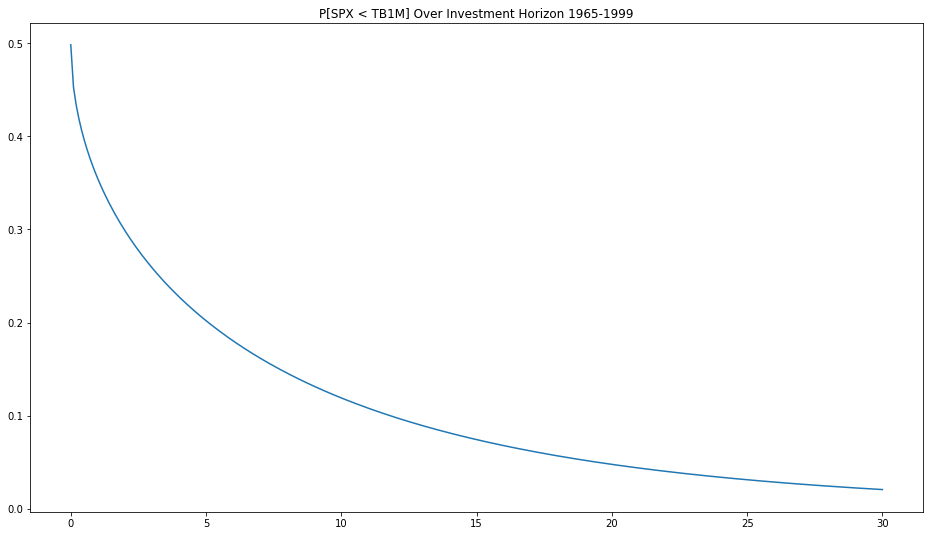

In [5]:
def fall_short(mu, sig, lower, nper=1):
    z = np.sqrt(nper)*(lower-mu)/sig
    return stats.norm.cdf(z)

horiz = "1965-1999"

mu = summ.loc["logSPXEX",(horiz, "mean")]
sig = summ.loc["logSPXEX",(horiz, "vol")]
lower = 0

prob1 = fall_short(mu, sig, lower)
print(f"(a) P[SPX < TB1M] @1yr   = {prob1:.4f}")

prob10 = fall_short(mu, sig, lower, nper=10)
prob30 = fall_short(mu, sig, lower, nper=30)
print(f"(b) P[SPX < TB1M] @10yrs = {prob10:.4f}")
print(f"    P[SPX < TB1M] @30yrs = {prob30:.4f}")

years = np.linspace(0.0001, 30, 300)
probs = [fall_short(mu, sig, lower, nper=i) for i in years]

plt.plot(years, probs)
plt.title(f"P[SPX < TB1M] Over Investment Horizon {horiz}")
plt.show()

#### 3. Suppose that at the end of 2021...

an investor is considering the issues Barnstable analyzed in 1999. Re-do the probability calculations for the sample 1965-2021. How different are the long-run
probabilities now considering this extra data?

As of the end of 2021, calculate the probability of underperforming the risk-free rate over the
next 30 years. That is, RMt,t+h underperforming Rf

t,t+h for 0 < h ≤ 30.

(a) P[SPX < TB1M] @1yr   = 0.3534
(b) P[SPX < TB1M] @10yrs = 0.1171
    P[SPX < TB1M] @30yrs = 0.0197


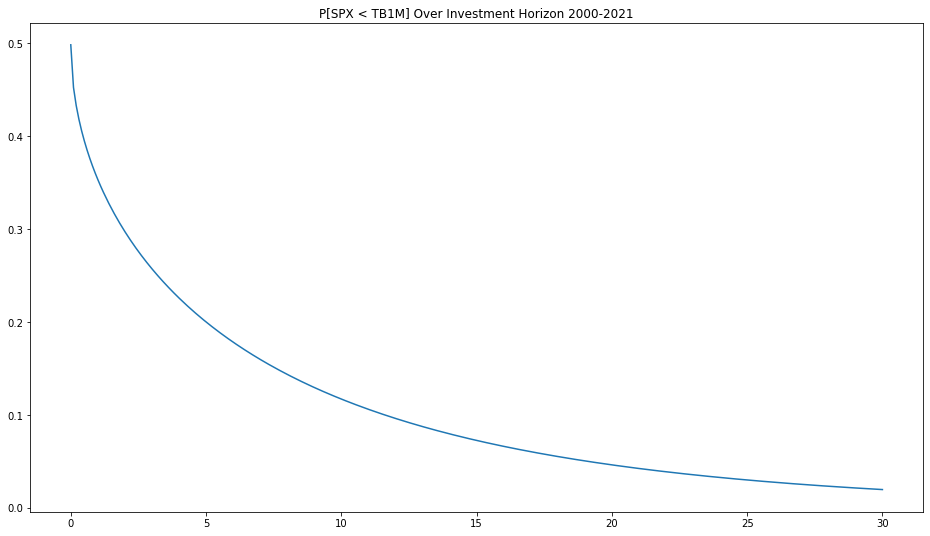

In [6]:
horiz = "2000-2021"

mu = data.loc["1965":"2021", "logSPXEX"].mean() * 12
sig = data.loc["1965":"2021", "logSPXEX"].std() * np.sqrt(12)
lower = 0

prob1 = fall_short(mu, sig, lower)
print(f"(a) P[SPX < TB1M] @1yr   = {prob1:.4f}")

prob10 = fall_short(mu, sig, lower, nper=10)
prob30 = fall_short(mu, sig, lower, nper=30)
print(f"(b) P[SPX < TB1M] @10yrs = {prob10:.4f}")
print(f"    P[SPX < TB1M] @30yrs = {prob30:.4f}")

years = np.linspace(0.0001, 30, 300)
probs = [fall_short(mu, sig, lower, nper=i) for i in years]

plt.plot(years, probs)
plt.title(f"P[SPX < TB1M] Over Investment Horizon {horiz}")
plt.show()

#### 4. Let’s consider how things turned out relative to Barnstable’s 1999 expectations.

(a) What was the probability (based on the 1999 estimate of µ,) that the 21-year market return,
RMt,t+21, would be smaller than that realized in 2000-2021? Note that we are asking about
the market return, not the excess market return. Continue using the 1965-1999 sample
standard deviation for σ.

(b) Suppose Barnstable had implemented the put-option strategy with the growing strike of
6%? Based on the 2000-2021 performance, what is the probability that the 2000-2029
cumulative market return will be low enough to make the puts in the money? For the
calculation, update your estimates of µ, σ to be the estimates based on 1965-2021.


In [7]:
mu1999 = summ.loc["logSPX",("1965-1999", "mean")]
sig1999 = summ.loc["logSPX",("1965-1999", "vol")]
mu2021 = summ.loc["logSPX",("2000-2021", "mean")]

prob_less = fall_short(mu1999, sig1999, mu2021, 21)
print(f"(a) P[SPX_2021 < SPX_1999] = {prob_less:.4f}")

# Part (b) put option ITM from here:
mu = data.loc["1965":"2021", "logSPX"].mean() * 12
sig = data.loc["1965":"2021", "logSPX"].std() * np.sqrt(12)

put_gro = np.log(1.06)
expiry = 29 # Expires in 30 years
elapsed = 21 # 22 years have passed

remain = expiry - elapsed # Remaining Tau of put option
spy_gro = elapsed*summ.loc["logSPX", ("2000-2021", "mean")] # growth over 2000-2021
mu_put = (put_gro*expiry - spy_gro) / remain
sig_put = sig

prob_itm = fall_short(mu, sig_put, mu_put, nper=remain)
print(f"(b) P[put ITM] = {prob_itm:.4f}")

(a) P[SPX_2021 < SPX_1999] = 0.0831
(b) P[put ITM] = 0.0679


## 3. Modeling Volatility and VaR

For the full sample of market returns, 1926-2021, calculate the LEVEL, (not log,) excess market
returns. We use this level excess return data throughout this section.

#### 1. Historic VaR.

Starting at t = 61, calculate the historic-based VaR, based on the expanding sample from period
1 (Jan 1926) to t − 1. By historic VaR, we mean simply taking the 5th quantile for the historic
sample up to time t − 1. Of course, a sample size that is not a multiple of 100 will require some
interpolation to get a 5th quantile. Your statistical package should handle this fine.
Denote this as ˜r
VaR,.05
t,historic, which is the best estimate of the time-t VaR based on data through
t − 1.

(a) Plot ˜r VaR,.05 t,historic over time.

(b) Calculate the frequency of periods in which ˜rt < r˜VaR,.05 t,historic.

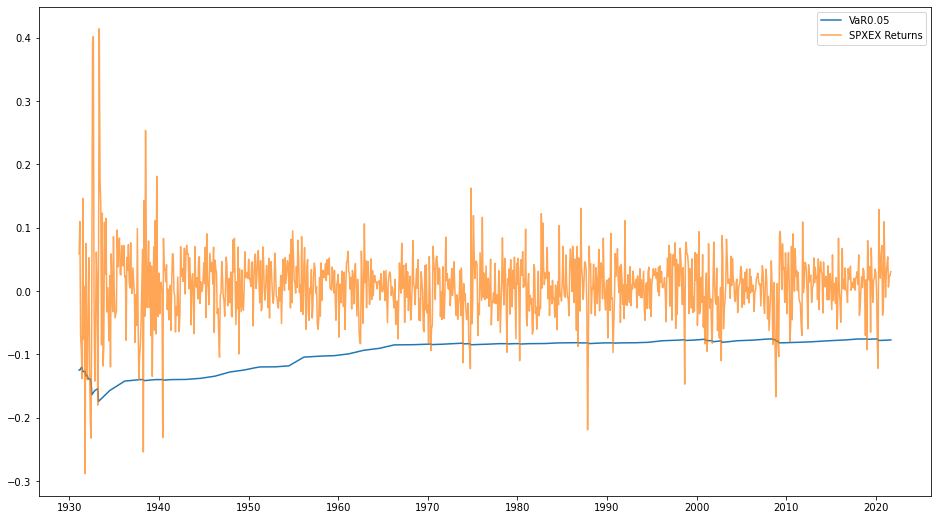

In [8]:
def hist_var(data, col, pi, window, rolling=True):
    steps = data.shape[0] - window
    
    vars = []
    for i in range(steps):
        d = data[col].iloc[i*rolling:i+window]
        v = d.quantile(pi)
        vars.append(v)
    
    vars = pd.Series(vars, index=data[col].iloc[window:].index)
    return vars

col = "SPXEX"
pi = 0.05
window = 60

d = data[col].iloc[window:]
vars = hist_var(data, col, pi, window, rolling=False)

plt.plot(vars, label=f"VaR{pi}")
plt.plot(d, label=f"{col} Returns", alpha=0.7)
plt.legend(); plt.show()

In [9]:
less_var = d < vars.shift(1)
print(f"(b) Frequency of periods in which r~t < VaR(r~thist, {pi}): {sum(less_var)/len(vars):.4f}")

(b) Frequency of periods in which r~t < VaR(r~thist, 0.05): 0.0294


(c) What drawbacks do you see in this historic VaR?

Using historic expanding VaR overestimates the risk because the dataset starts in 1926: 3 years before the Great Depression. As a result, actual returns passing the VaR(0.05) threshhold are severly underestimated. Great Depression volatility remained in the "memory" of the model and therefore set VaR(0.05) unrealistically low. Furthermore, using the expanding method converges VaR(0.05) to that of the sample. A more appropriate implementation would be using a rolling method that "forgets" volatility from decades ago.

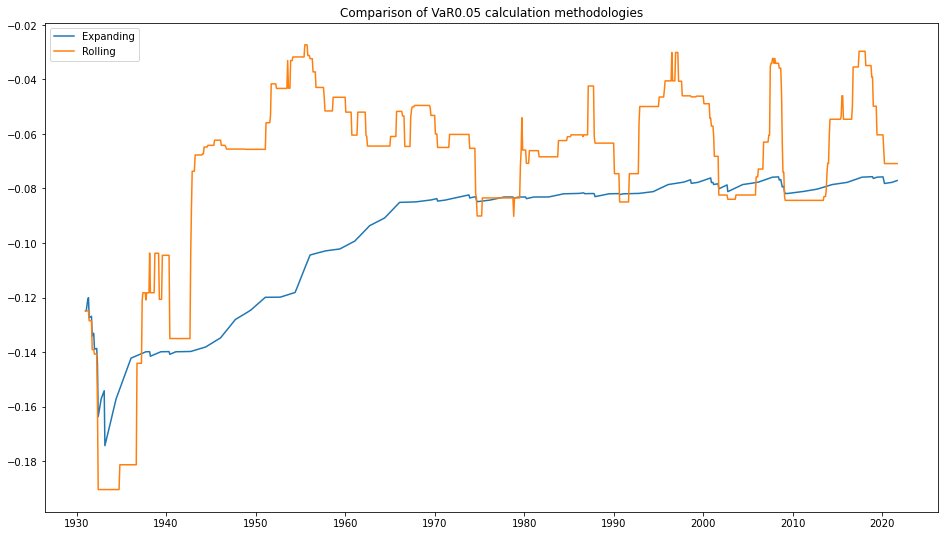

In [10]:
plt.plot(data[col].expanding(window).quantile(pi).dropna(), label="Expanding")
plt.plot(data[col].rolling(window).quantile(pi).dropna(), label="Rolling")
plt.title(f"Comparison of VaR{pi} calculation methodologies")
plt.legend()
plt.show()

#### 2. Volatility

We will calculate a time-series of volatility estimates using a few different methods. For each,
we use σt to denote our estimate of the time-t return volatility, as based on data over periods 1
(Jan 1926) through t − 1, but not including t itself.

• Expanding Series

Begin the calculation at t = 61, so that the first estimate is based on 60 data points.

• Rolling Window

Use m = 60, and begin the calculation at the t = 61, (so that the calculation has a full 60
data points.)

• Exponentially Weighted Moving Average (EWMA)

Rather than estimating θ, simply use θ = 0.97, and initialize with σ1 = 0.15.

• GARCH(1,1) model.

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation
implementation is fine.3

(a) For each of these three methods, plot σt. (Plot the vol, not the variance.)

In [11]:
# Expanding and Rolling variances
expa = (data["SPXEX"]**2).expanding(window).mean().dropna()
roll = (data["SPXEX"]**2).rolling(window).mean().dropna()

# EWMA
def ewma(series, theta, alpha, variance):
    dat = pd.Series([variance]).append(series ** 2)
    dat = pd.DataFrame(dat, columns=["EWMA"])
    ewma = dat.ewm(alpha=alpha, adjust=False).mean()[dat.index[1]:]
    return ewma

theta = 0.97
alpha = 1-theta
sigma_0 = (0.15/np.sqrt(12)) ** 2

ewma = ewma(data["SPXEX"], theta, alpha, sigma_0)

# GARCH
def hist_garch(data, window, order, rolling=True):
    steps = data.shape[0] - window
    
    garches = []
    for i in range(steps):
        d = data.iloc[i*rolling:i+window]
        modfit = arch.arch_model(d.values, vol="GARCH", p=order[0], q=order[1],
                                 rescale=False).fit(disp=0)
        g = modfit.forecast(horizon=1, reindex=True)
        
        garches.append(g.variance.values[-1][0])
    
    garches = pd.Series(garches, index=data.iloc[window:].index)
    return garches

gvol = hist_garch(data["SPXEX"], window, order=(1,1))

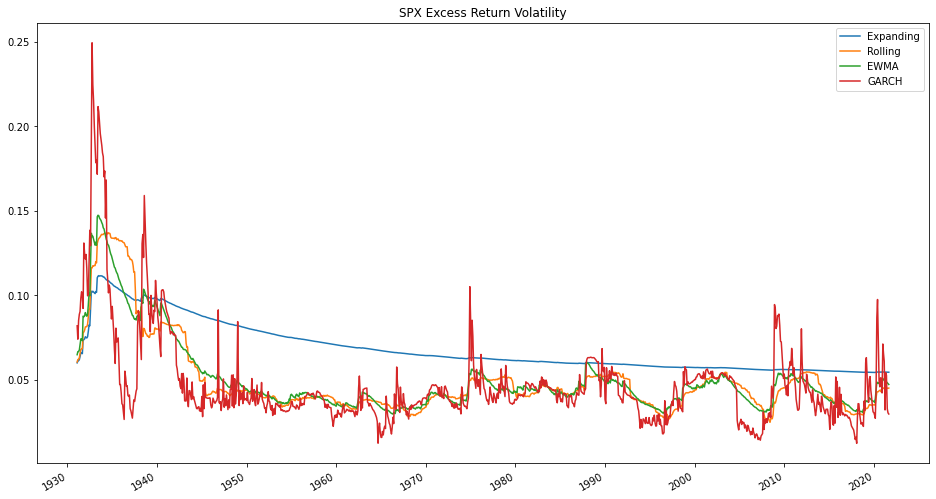

In [12]:
vol_models = pd.DataFrame([expa, roll, ewma["EWMA"], gvol],
                          index=["Expanding", "Rolling", "EWMA", "GARCH"]).T.dropna()
vol_models = np.sqrt(vol_models)

vol_models.plot()
plt.title("SPX Excess Return Volatility")
plt.show()

(b) For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight sim-
plification of the normal VaR formula, by dropping µ from that formula, and rounding the
normal distribution z-score to -1.65.
r˜VaR,0.05
t,vol = −1.65σt

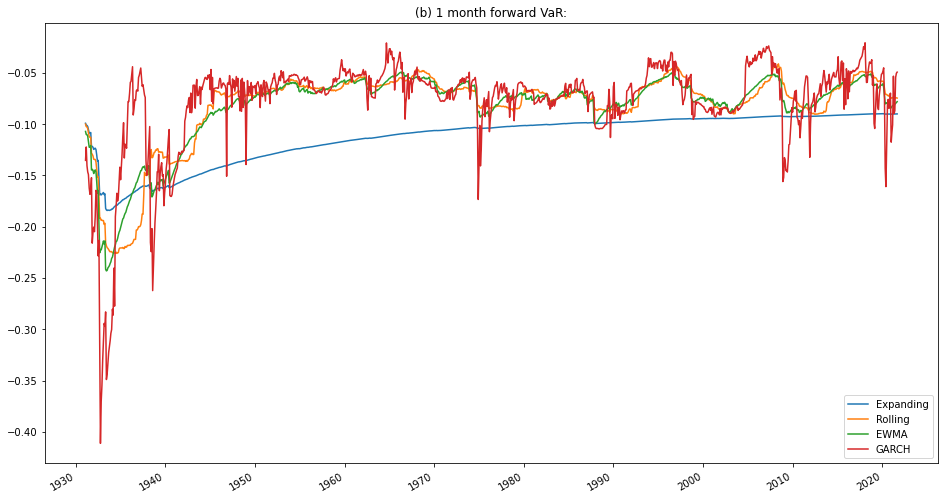

In [13]:
zscore = -1.65
fwd_var = zscore * vol_models

fwd_var.plot()
plt.title("(b) 1 month forward VaR:")
plt.show()

(c) For each of these three vol-based VaR estimates, calculate the frequency of periods in which
r˜t < r˜VaR,.05
t,vol .

(d) Compare and contrast your results among each other and relative to the historic method in the previous problem.

The expanding series shows a much smoother curve in volatility and VaR prediction than other methods. This is because when t gets larger, the recent return has much lower effect on the prediction, dragging the prediction curve to nearly constant. The low frequency of return < VaR(0.05) indicates expanding series has much smaller tail than normal distribution. This is true because the series finally converges to a constant which has no tail. The expanding series may provide a good estimate for the mean volatility over the whole period, but will be useless if we what to track some trend of the volatility.

On the contrary, the estimation from GARCH(1,1) model is much more volatile than other methods, resulting in a larger tail than normal distribution. This because GARCH(1,1) model tends to put more weights on the return on t-1 to predict volatility on t. If we get larger p or q to the model, we may get a prediction more similar to the remaining 2 methods as well as the normal distribution.

Rolling window and EWMA have similar curve on the estimation of volatility and VaR. They both keep a balance between old and new return data. Rolling window uses a long period of recent data and EWMA give weights to both t-1 data and older data. The difference is rolling window returns with larger tail and EWMA return smaller tail, but they both return tail closer to normal distribution than expanding series and GARCH(1,1).

In [14]:
truth = data["SPXEX"][window:]

freq = {c: sum(fwd_var[c].shift(1) > truth)/len(truth) for c in fwd_var.columns}
print("(c) Frequency of ")
pd.DataFrame(freq, index=["frequency"])

(c) Frequency of 


,Expanding,Rolling,EWMA,GARCH
frequency,0.0175,0.0478,0.0423,0.0588
